# Monthly NDVI Anomaly

* **Products used:** 
[ndvi_anomaly](https://explorer.digitalearth.africa/products/ndvi_anomaly)

## Background

Digital Earth Africa's Monthly NDVI Anomaly service provides estimate of vegetation condition, for each caldendar month, against the long-term baseline condition measured for the month from 1984 to 2020 in the [NDVI Climatology](https://docs.digitalearthafrica.org/en/latest/data_specs/NDVI_Climatology_specs.html). 

A standardised anomaly is calculated by subtracting the long-term mean from an observation of interest and then dividing the result by the long-term standard deviation. 
The equation below applies for monthly NDVI anomalies:

\begin{equation}
\text{Standardised anomaly }=\frac{NDVI_{month, year}-NDVI_{month}}{\sigma}
\end{equation}

where $NDVI_{month, year}$ is the NDVI measured for a month in a year, $NDVI_{month}$ is the long-term mean for this month from 1984 to 2020, and $\sigma$ is the long-term standard deviation. A standarised anomaly therefore measures the direction and significance of vegeation change against normal conditions. 

Postive NDVI anomaly values indicate vegetation is greener than average conditions, and are usually due to increased rainfall in a region. Negative values indicate additional plant stress relative to the long-term average. The NDVI anomaly service is therefore effective for understanding the extent, intensity and impact of a drought. 

Abrupt and significant negative anomalies may also be caused by fire disturbance.

Further details on the product are available in the [NDVI Anomaly technical specifications](https://docs.digitalearthafrica.org/en/latest/data_specs/NDVI_Anomaly_specs.html) documentation.

**Important details:**

* Datacube product name: `ndvi_anomaly`
* Measurements
    * `ndvi_mean`: Mean NDVI for a month.
    * `ndvi_std_anomaly`: Standardised NDVI anomaly for a month
    * `clear_count`: Number of clear observations in a month 
* Date-range: monthly from January 2017
* Spatial resolution: 30m

From August 2022, the Monthly NDVI Anomaly is generated as a low latency product, i.e. anomaly for a month is generated on the 5th day of the following month. This ensures data is available shortly after the end of a month and all Landat 9 and Sentinel-2 observations are included. Not all landsat 8 observations for the month will be used, because the Landsat 8 Surface Refelectance product from USGS has a latency of over 2 weeks (see [Landsat Collection 2 Generation Timeline](https://www.usgs.gov/media/images/landsat-collection-2-generation-timeline)).

From January 2017 to July 2022, all available Landsat 8, Landsat 9 and Sentinel-2 observations are used in the calculation of the anomalies.

## Description

In this notebook we will load the NDVI Anomaly product using `dc.load()` to return mean, standard deviation, and clear observation count for each calendar month. A final section explores an example analysis using the product.

Topics covered include:
1. Inspecting the NDVI Anomaly product and measurements available in the datacube.
2. Using the native `dc.load()` function to load in NDVI Anomaly for a defined area.
3. Visualise the mean NDVI and standardised anomalies.
4. Plot the phenology curve of croplands.
5. Extract mean NDVI and anomalies for a selected month and region.
6. Compare mean NDVI to conditions observed in the previous years.

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

### Load packages

In [48]:
import datacube
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from odc.ui import with_ui_cbk
from datacube.utils.geometry import Geometry

from deafrica_tools.plotting import display_map
from deafrica_tools.spatial import xr_rasterize

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Connect to the datacube

In [4]:
dc = datacube.Datacube(app='NDVI_anomaly')

## Available measurements

### List measurements

The table printed below shows the measurements available in the NDVI Anomaly product. The mean NDVI, standardised NDVI anomaly, and clear obervations count can be loaded for each calendar month.

In [5]:
product_name = 'ndvi_anomaly'

dc_measurements = dc.list_measurements()
dc_measurements.loc[product_name].drop('flags_definition', axis=1)

,name,dtype,units,nodata,aliases
measurement,,,,,
ndvi_mean,ndvi_mean,float32,1,NaN,[NDVI_MEAN]
ndvi_std_anomaly,ndvi_std_anomaly,float32,1,NaN,[NDVI_STD_ANOMALY]
clear_count,clear_count,int8,1,0.0,"[CLEAR_COUNT, count]"


### Analysis parameters

This section defines the analysis parameters, including:

* `lat, lon, buffer`: center lat/lon and analysis window size for the area of interest
* `resolution`: the pixel resolution to use for loading the `ndvi_anomaly`. The native resolution of the product is 30 metres i.e. `(-30,30)` as the product is Landsat derived.
* `time_range`: time range for loading the monthly anomalies
The default location is an cropping region in Western Cape, South Africa where an irrigation scheme along a river is surrounded by rain-fed cropping.

In [6]:
lat, lon = -34.0602, 20.2800  # capetown

buffer = 0.08

resolution = (-30, 30)

# join lat, lon, buffer to get bounding box
lon_range = (lon - buffer, lon + buffer)
lat_range = (lat + buffer, lat - buffer)

time = '2022-01', '2022-07'

## View the selected location

The next cell will display the selected area on an interactive map. Feel free to zoom in and out to get a better understanding of the area you'll be analysing. Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [7]:
display_map(lon_range, lat_range)

## Load data

Below we use the `dc.load` function to load all the measurements over the region specified above. 


In [9]:
# load data
ndvi_anom = dc.load(
    product="ndvi_anomaly",
    resolution=resolution,
    x=lon_range,
    y=lat_range,
    time=time,
    progress_cbk=with_ui_cbk(),
)

print(ndvi_anom)

<xarray.Dataset>
Dimensions:           (time: 2, y: 567, x: 515)
Coordinates:
  * time              (time) datetime64[ns] 2022-06-15T23:59:59.999999 2022-0...
  * y                 (y) float64 -4.091e+06 -4.091e+06 ... -4.108e+06
  * x                 (x) float64 1.949e+06 1.949e+06 ... 1.964e+06 1.964e+06
    spatial_ref       int32 6933
Data variables:
    ndvi_mean         (time, y, x) float32 0.6107 0.6186 0.633 ... 0.8326 0.8383
    ndvi_std_anomaly  (time, y, x) float32 -0.2075 0.02818 ... 0.8122 0.7779
    clear_count       (time, y, x) int8 11 11 11 11 11 11 ... 10 10 10 10 10 10
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


## Plotting monthly NDVI and anomalies


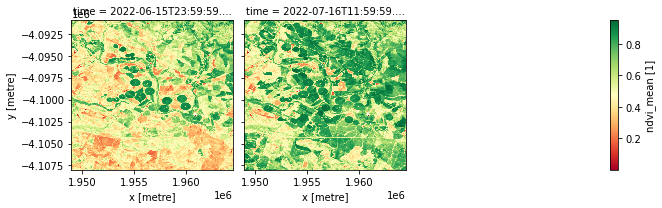

In [27]:
ndvi_anom.ndvi_mean.plot.imshow(col='time', col_wrap=3, cmap="RdYlGn");

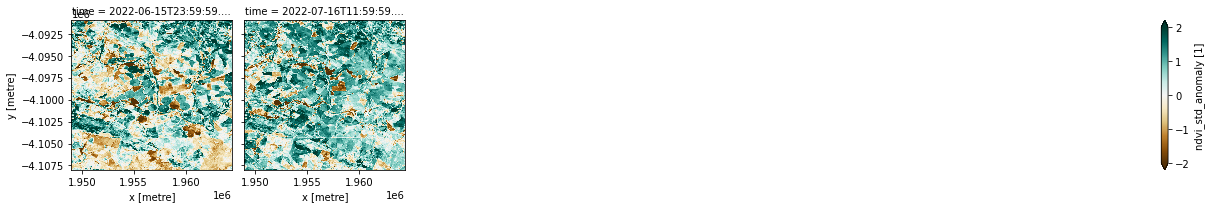

In [26]:
ndvi_anom.ndvi_std_anomaly.plot.imshow(col='time', col_wrap=6, cmap="BrBG", vmin=-2, vmax=2);

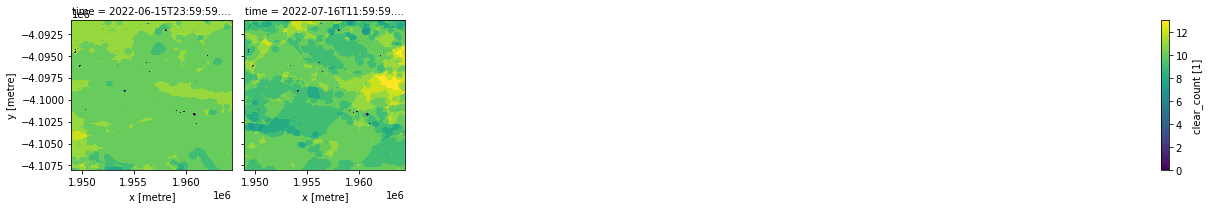

In [16]:
ndvi_anom.clear_count.plot.imshow(col='time', col_wrap=6, cmap="viridis");

## Plot NDVI phenology

We can use the monthly NDVI to extract phenology curve for specific landscapes. 
Limiting our analysis of the area above to a crop mask enables us to investigate the phenology of cropland.

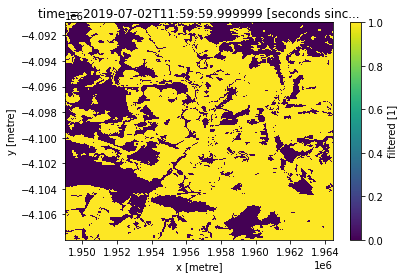

In [30]:
#Load the cropmask dataset for the region

cm = dc.load(product="crop_mask_southern",
             measurements='filtered',
            resampling='nearest', 
            like=ndvi_clim.geobox).filtered.squeeze()

cm.plot.imshow();

In [31]:
#Mask the datasets with the crop mask
ndvi_anom_crop = ndvi_anom.where(cm)

### Plot phenology curve

Below we summarise the datasets spatially by taking the mean across the `x` and `y` dimensions, this will leave us with the average trend through `time` for the region we've loaded.

From the phenology plot, we can conclude that crop growth in this area commenced around May and continued until harvest around October.

For a more detailed vegetation phenology analysis, see the notebook [Vegetation Phenology notebook](../Real_world_examples/Vegetation_phenology.ipynb)

In [22]:
ndvi_mean_crop = ndvi_anom_crop.ndvi_mean.mean(['x','y'])

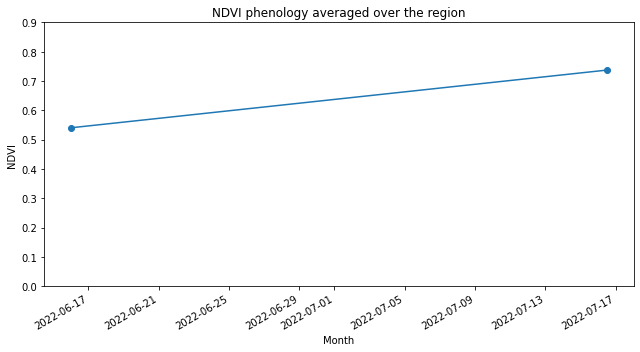

In [23]:
ndvi_mean_crop.plot(figsize=(9,5), marker='o')
plt.ylim(0,0.9)
plt.title('NDVI phenology averaged over the region')
plt.xlabel('Month')
plt.ylabel('NDVI')
plt.tight_layout()

## Extract NDVI anomalies for a selected month and region

In [42]:
# Select a country
country = "Uganda"

# year and month for anomaly
year_month = "2022-06"

# pixel resolution can got as low as (-30,30) metres,
# but make larger for big areas.
resolution = (-120, 120)

# how to chunk the dataset for use with dask
dask_chunks = dict(x=1000, y=1000)

### Load the African Countries shapefile
This shapefile contains polygons for the boundaries of African countries and will allows us to calculate NDVI anomalies within a chosen country


In [36]:
african_countries = gpd.read_file('../Supplementary_data/Rainfall_anomaly_CHIRPS/african_countries.geojson')

### List countries
You can change the country in the analysis parameters cell to any African country. A complete list of countries is printed below.

In [37]:
print(np.unique(african_countries.COUNTRY))

['Algeria' 'Angola' 'Benin' 'Botswana' 'Burkina Faso' 'Burundi' 'Cameroon'
 'Cape Verde' 'Central African Republic' 'Chad' 'Comoros'
 'Congo-Brazzaville' 'Cote d`Ivoire' 'Democratic Republic of Congo'
 'Djibouti' 'Egypt' 'Equatorial Guinea' 'Eritrea' 'Ethiopia' 'Gabon'
 'Gambia' 'Ghana' 'Guinea' 'Guinea-Bissau' 'Kenya' 'Lesotho' 'Liberia'
 'Libya' 'Madagascar' 'Malawi' 'Mali' 'Mauritania' 'Morocco' 'Mozambique'
 'Namibia' 'Niger' 'Nigeria' 'Rwanda' 'Sao Tome and Principe' 'Senegal'
 'Sierra Leone' 'Somalia' 'South Africa' 'Sudan' 'Swaziland' 'Tanzania'
 'Togo' 'Tunisia' 'Uganda' 'Western Sahara' 'Zambia' 'Zimbabwe']


### Setup polygon
The country selected needs to be transformed into a geometry object to be used in the load_ard function.

In [40]:
idx = african_countries[african_countries['COUNTRY'] == country].index[0]
geom = Geometry(geom=african_countries.iloc[idx].geometry, crs=african_countries.crs)

### Load NDVI anomaly

In [61]:
ndvi_anom = dc.load(
    product="ndvi_anomaly",
    resolution=resolution,
    geopolygon=geom,
    time=year_month,
    dask_chunks=dask_chunks,
    # progress_cbk=with_ui_cbk(),
).squeeze()

print(ndvi_anom)

<xarray.Dataset>
Dimensions:           (y: 6070, x: 4364)
Coordinates:
    time              datetime64[ns] 2022-06-15T23:59:59.999999
  * y                 (y) float64 5.397e+05 5.396e+05 ... -1.885e+05 -1.886e+05
  * x                 (x) float64 2.853e+06 2.854e+06 ... 3.377e+06 3.377e+06
    spatial_ref       int32 6933
Data variables:
    ndvi_mean         (y, x) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    ndvi_std_anomaly  (y, x) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    clear_count       (y, x) int8 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


In [62]:
african_countries = african_countries.to_crs('epsg:6933')
mask = xr_rasterize(african_countries[african_countries['COUNTRY'] == country], ndvi_anom)

In [63]:
ndvi_anom = ndvi_anom.where(mask==1)

### Plot NDVI climatology, monthly mean, and standardised anomaly


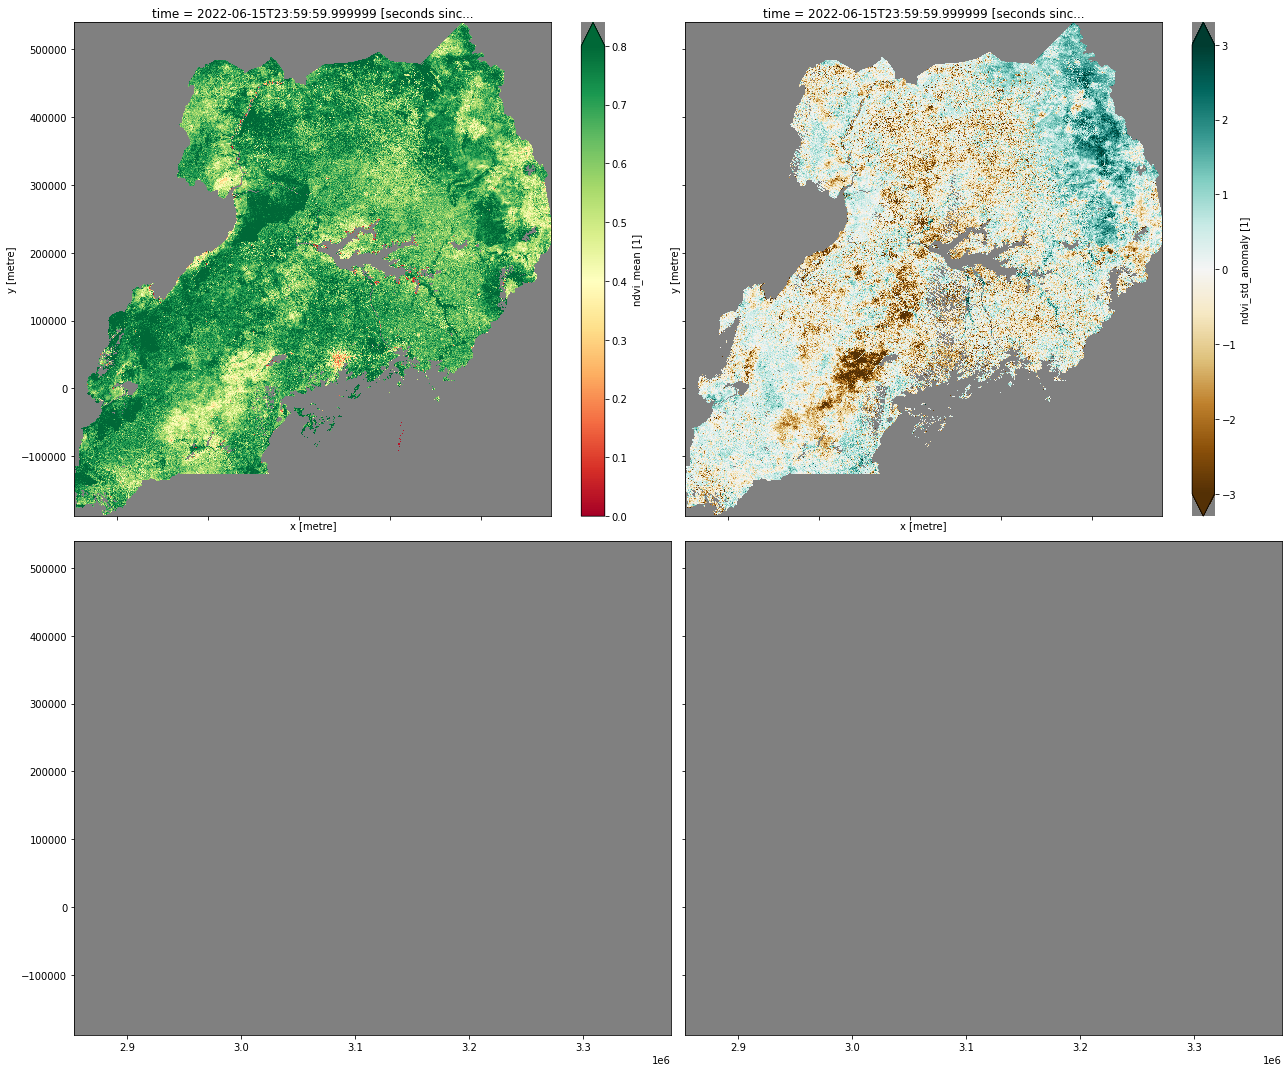

In [65]:
# plot all layers
plt.rcParams["axes.facecolor"] = "gray"  # makes transparent pixels obvious
fig, ax = plt.subplots(2, 2, sharey=True, sharex=True, figsize=(18, 15))

ndvi_anom.ndvi_mean.plot.imshow(ax=ax[0, 0], cmap="RdYlGn",vmin=0,vmax=0.8)
#ax[0, 0].set_title("NDVI: " + year + " " + month + " mean")

ndvi_anom.ndvi_std_anomaly.plot.imshow(ax=ax[0, 1], cmap="BrBG", vmin=-3, vmax=3)
#ax[0, 1].set_title("NDVI: " + year + " " + month + " standardised anomaly")
plt.tight_layout();

## Compare monthly NDVI to conditions observed in the previous years 

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [19]:
print(datacube.__version__)

1.8.6


**Last Tested:**

In [20]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2022-02-22'